In [3]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import seaborn as sns

In [4]:
# load normalized data and true labels
scaled_data = pd.read_csv('../data/GSE910_SMOTE_scaled_top100.csv', index_col=0)
labels = pd.read_csv('../data/GSE910_SMOTE_labels_top100.csv',index_col=0)

In [5]:
# fit PCA to data
pca = PCA(n_components=10)
pca.fit_transform(scaled_data)

array([[-1.83340090e+02, -3.85947785e+02,  2.41507256e+01, ...,
        -2.27366415e+00,  1.69726012e+00, -8.53333307e-01],
       [-3.19789788e+02,  5.26913016e+02,  1.96019582e+01, ...,
         1.24843058e+00,  1.77355136e+01, -6.03458552e+00],
       [-2.69320294e+02,  1.61195930e+02,  1.71831087e+01, ...,
         5.89224744e+00,  1.09228681e+01, -5.88501409e+00],
       ...,
       [-2.05452369e+02, -2.79922578e+02,  2.47014211e-03, ...,
         4.68786660e+00, -3.92246069e+00, -1.02795411e+00],
       [ 1.36318504e+03, -1.48502955e+02, -2.15873624e+00, ...,
         9.03865502e+00,  8.78313596e-02,  1.44548563e+00],
       [ 9.43347605e+02, -2.11341608e+02, -7.93493330e+00, ...,
         5.07332812e+00,  7.50284937e-02,  3.35132998e+00]])

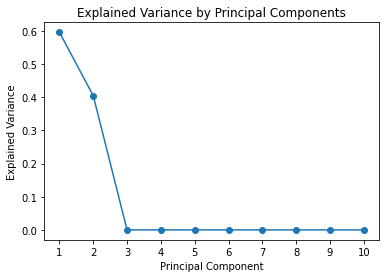

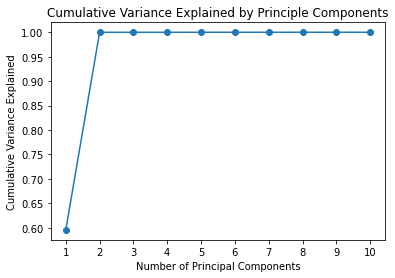

In [6]:
# use elbow method on variance explained to select optimal number of principal components
explained_variance = pca.explained_variance_ratio_

# plot explained variance against principal component
plt.plot(range(1, len(explained_variance) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

# also check cumulative variance explained
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Variance Explained by Principle Components')
plt.xlabel('Number of Principal Components')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.ylabel('Cumulative Variance Explained') ;

In [7]:
# optimal pcs
pca2 = PCA(n_components=2)
PCAreduced_data = pca2.fit_transform(scaled_data)

In [8]:
# Get the loadings (coefficients) for the first principal components
loadings = pca2.components_[:2]

# Get the absolute values of the loadings
# abs_loadings = np.abs(loadings)

# Find the indices of top features for each principal component in descending order
top_features_indices = np.argsort(loadings, axis=1)[:, ::-1]

# list genes
genes = list(scaled_data.columns)

# number of pcs
num_pcs = top_features_indices.shape[0]

# for each pc find the top contributing elements
for pc in range(num_pcs):

    # top features in each pc
    idx = top_features_indices[pc]
    first = idx[0]
    last = idx[-1]

    # list out name of pcs
    print(f"Top positive feature for Principal Component {pc + 1}: {genes[first]}")
    print(f"Top negative feature for Principal Component {pc + 1}: {genes[last]}")


Top positive feature for Principal Component 1: VGF
Top negative feature for Principal Component 1: TYRP1
Top positive feature for Principal Component 2: TYRP1
Top negative feature for Principal Component 2: APOD


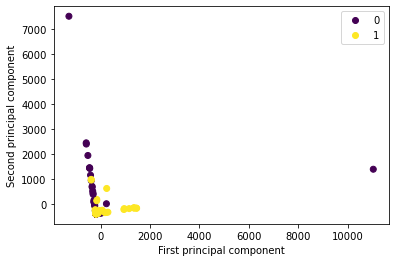

In [9]:
fig = plt.scatter(PCAreduced_data[:, 0], PCAreduced_data[:, 1], c=labels['Response'])

# Set labels for x and y axes
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend(handles=fig.legend_elements()[0], labels=list(set(labels['Response'])))
plt.show()


               PC1       PC2
RN7SL2    0.000323 -0.000340
FTL       0.000101 -0.000063
MT-CO3    0.000116  0.000137
MT-CO2    0.000130  0.000114
MT-ATP8   0.000156  0.000141
...            ...       ...
HP       -0.000125 -0.000127
HLA-A     0.000174 -0.000216
IGHV3-7   0.000213 -0.000160
HLA-DRB1 -0.000070 -0.000419
KRTDAP   -0.000163  0.000017

[100 rows x 2 columns]


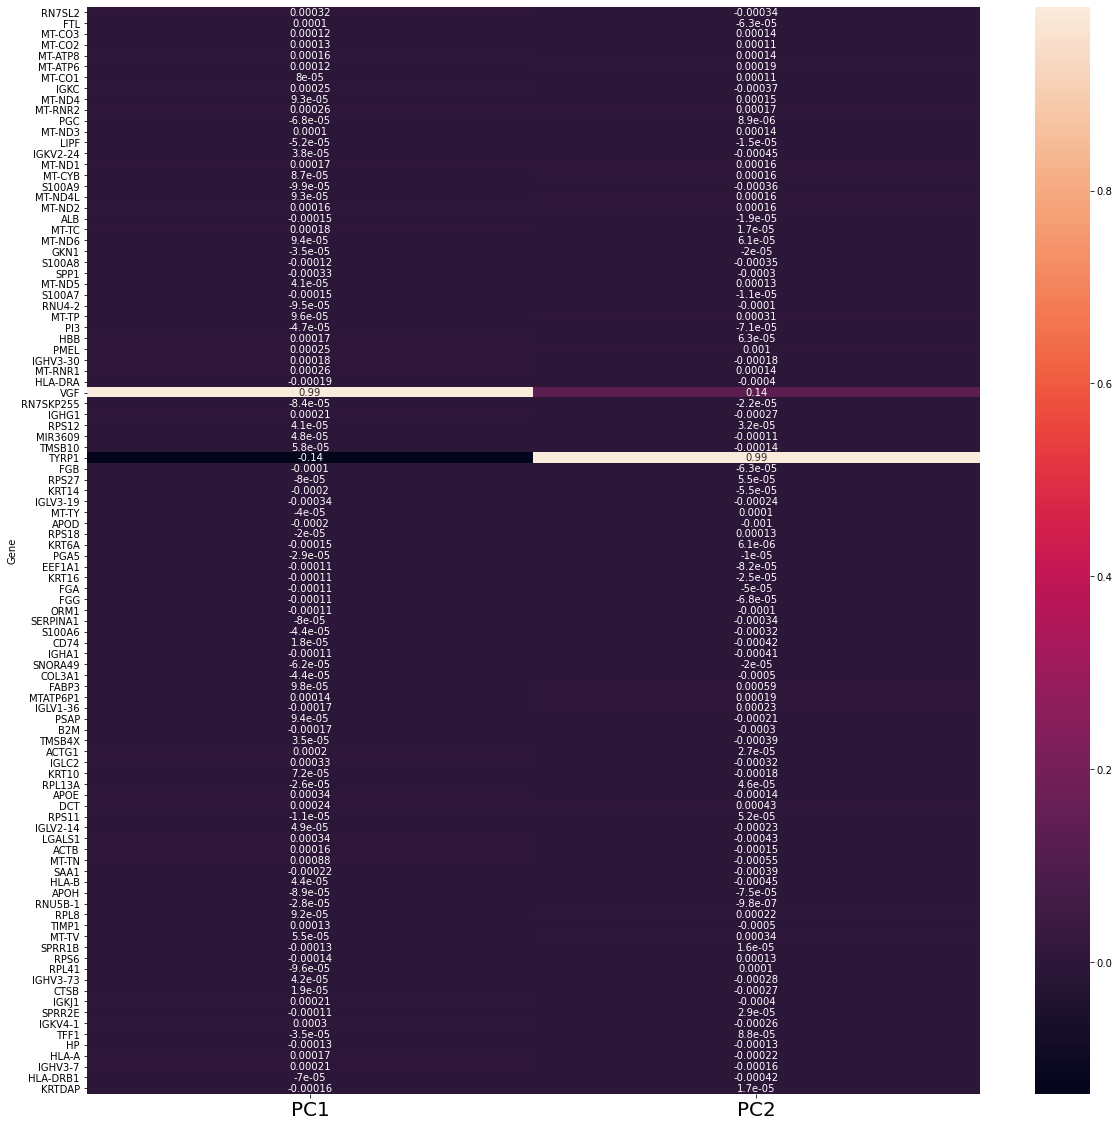

In [34]:
# heatmap of loadings
loadings = pd.DataFrame(pca2.components_.T, columns=['PC1', 'PC2'], index=genes )
print(loadings)

plt.rcParams['figure.figsize'] = [20, 20]
plt_loadings = sns.heatmap(loadings, xticklabels = True, yticklabels = True, annot = True)
plt_loadings.set(ylabel = 'Gene')
plt_loadings.tick_params(axis = 'y', labelsize = 10)
plt_loadings.tick_params(axis = 'x', labelsize = 20)

plt.savefig('../figures/GSE910_PCA_top100_loadings.png')

In [11]:
# Train a logistic regression model using the top PCs before optimizing hyperparameters
X_train, X_test, y_train, y_test = train_test_split(PCAreduced_data, labels['Response'], test_size = 0.3, random_state=1210)
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_train)
training_accuracy = accuracy_score(y_pred, y_train)
y_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test)
print("Training accuracy before hyperparameter optimization:", training_accuracy)
print("Test set accuracy before hyperparameter optimization:", test_accuracy)

Training accuracy before hyperparameter optimization: 0.6419753086419753
Test set accuracy before hyperparameter optimization: 0.7428571428571429


In [12]:
# cv of PCA (number of PCs) and L1 logistic regression

pipeline = Pipeline([
    ('pca', PCA()),
    ('clf', LogisticRegression(penalty = 'l1'))

])

hyperparameters = {
    'pca__n_components': list(range(1, 10)),
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [1000]
}

grid_search = GridSearchCV(pipeline, hyperparameters,  cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters:", best_params)

Best hyperparameters: {'clf__C': 10, 'clf__max_iter': 1000, 'clf__solver': 'liblinear', 'pca__n_components': 2}


/Users/sophiesun/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
350 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sophiesun/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sophiesun/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/sophiesun/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self

In [13]:
# Train a logistic regression model using the top PCs after optimizing hyperparameters
y_pred = best_model.predict(X_train)
training_accuracy = accuracy_score(y_pred, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test)

print("Training accuracy after hyperparameter optimization:", training_accuracy)
print("Test set accuracy after hyperparameter optimization:", test_accuracy)

Training accuracy after hyperparameter optimization: 0.6419753086419753
Test set accuracy after hyperparameter optimization: 0.7428571428571429


In [14]:
# export cluster assignments
predictions = best_model.predict(PCAreduced_data)
clusters_pca = pd.concat([pd.DataFrame(labels), pd.DataFrame(predictions, columns = ['cluster'])], axis = 1)
clusters_pca.to_csv('../data/clusters_pca.csv')